# Models de classification en fonction du grade Gleason pour la séquence T2

# Import des bibliothèques

In [136]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Import des données

[Text(0.5, 1.0, 'T2W Gleason Grad Score repartition')]

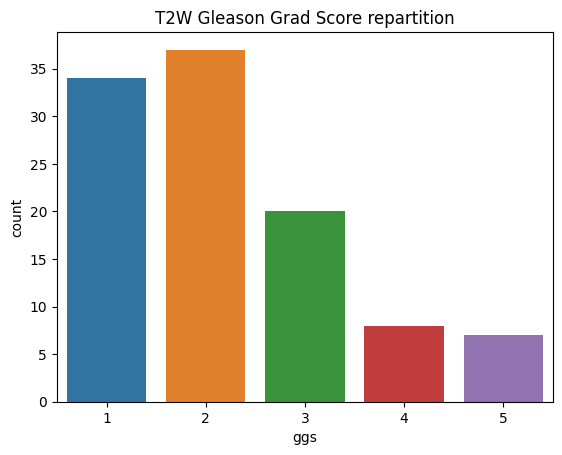

In [137]:
t2w_data_dir = "lesions/ADC_T2_Images_Analyses/ADC_T2_features/Data_merge/ProstateX_t2_Dataset.csv"

t2w_df = pd.read_csv(t2w_data_dir)

sns.countplot(x=t2w_df['ggs']).set(title="T2W Gleason Grad Score repartition")

Après extraction en fonction du grade de Gleason et suppression des données n'ayant pas d'informations clinique "No biopsire information", nous obtenons le graphe si dessus avec la taille de chaque grade

T2W est une séquence de diffusion IRM comportant au total 202 donées Images patient dont chaque image patient contient en moyenne 15 slices

In [138]:

t2w_df.drop(['Unnamed: 0','Unnamed: 0.1','sub'], axis = 1, inplace = True)

t2w_df.head(10)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ggs
0,0.857749,0.118325,3.075974,25.995928,28.017851,30.463092,27.000000,31.400637,1203.166667,22.297974,...,0.002382,0.522377,425.472608,0.001702,0.167569,0.005155,2934.630260,0.227422,2.931332,2
1,0.452384,0.071241,4.728154,66.368899,77.006493,77.162167,35.057096,78.166489,5323.541667,30.024236,...,0.005113,0.393420,144.427815,0.002481,0.718044,0.001304,2842.029766,0.072409,1.326968,2
2,0.724301,0.137079,5.875069,42.859122,38.013156,48.270074,48.000000,51.701064,4761.041667,31.042895,...,0.004510,0.361832,124.245132,0.001925,0.640161,0.001378,3152.794271,0.054361,1.937899,2
3,0.653247,0.156951,7.438026,47.390817,37.121422,51.478151,49.040799,53.535035,6400.458333,30.957903,...,0.002979,0.464772,308.302774,0.001750,0.626123,0.001019,4463.215583,0.124210,0.916435,4
4,0.427473,0.133708,4.478159,33.492161,36.013886,36.769553,19.235384,38.327536,965.333333,14.317008,...,0.005270,0.545373,336.536125,0.003556,0.139523,0.008186,3963.925893,0.293051,6.903546,3
5,0.720404,0.093236,2.826698,30.317793,29.068884,29.614186,29.068884,33.555923,980.416667,21.841045,...,0.006935,0.587280,304.729524,0.004648,0.164098,0.006741,4006.001863,0.285674,5.194441,3
6,0.631565,0.092699,3.055723,32.963876,24.020824,37.161808,34.014703,38.091994,1391.791667,20.818820,...,0.007608,0.479131,186.048437,0.005047,0.216292,0.005209,2993.459903,0.136891,4.538921,1
7,0.514092,0.108496,3.444604,31.748705,27.018512,37.536649,20.223748,38.884444,990.958333,16.321748,...,0.012676,0.629953,323.290777,0.011200,0.147792,0.006530,5323.228326,0.293927,5.666425,1
8,0.771357,0.150980,3.770117,24.971009,26.019224,30.364453,22.203603,32.756679,1093.875000,19.261557,...,0.006221,0.426333,189.334323,0.003480,0.133536,0.007159,3083.812637,0.118852,7.824331,1
9,0.679685,0.172246,4.862498,28.229965,29.017236,32.695565,26.000000,33.630343,1370.041667,19.187498,...,0.008847,0.547075,270.690722,0.006748,0.232724,0.004871,3519.142095,0.267451,3.174963,3


# Mise à l'échel des données

In [139]:
from imblearn.over_sampling import SMOTE
import sklearn as sk

y = t2w_df['ggs']
t2w_df.drop(['ggs'], axis=1, inplace=True)

smote = SMOTE(sampling_strategy={1:35,3:35,4:15,5:12})

X_resampled, y_resampled = smote.fit_resample(t2w_df, y)

[Text(0.5, 1.0, 'T2W Gleason Grad Score repartition')]

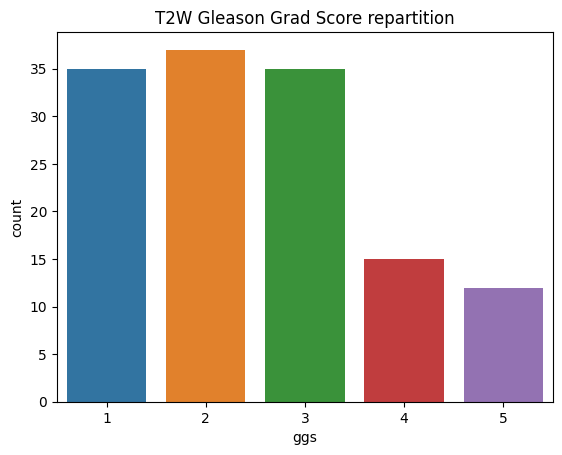

In [140]:
t2w_df = pd.concat((X_resampled, y_resampled), axis=1)
t2w_df = sk.utils.shuffle(t2w_df)
t2w_df = sk.utils.shuffle(t2w_df)
sns.countplot(x=t2w_df['ggs']).set(title="T2W Gleason Grad Score repartition")

# La matrice de corrélation entre nos marqueurs quantitatifs

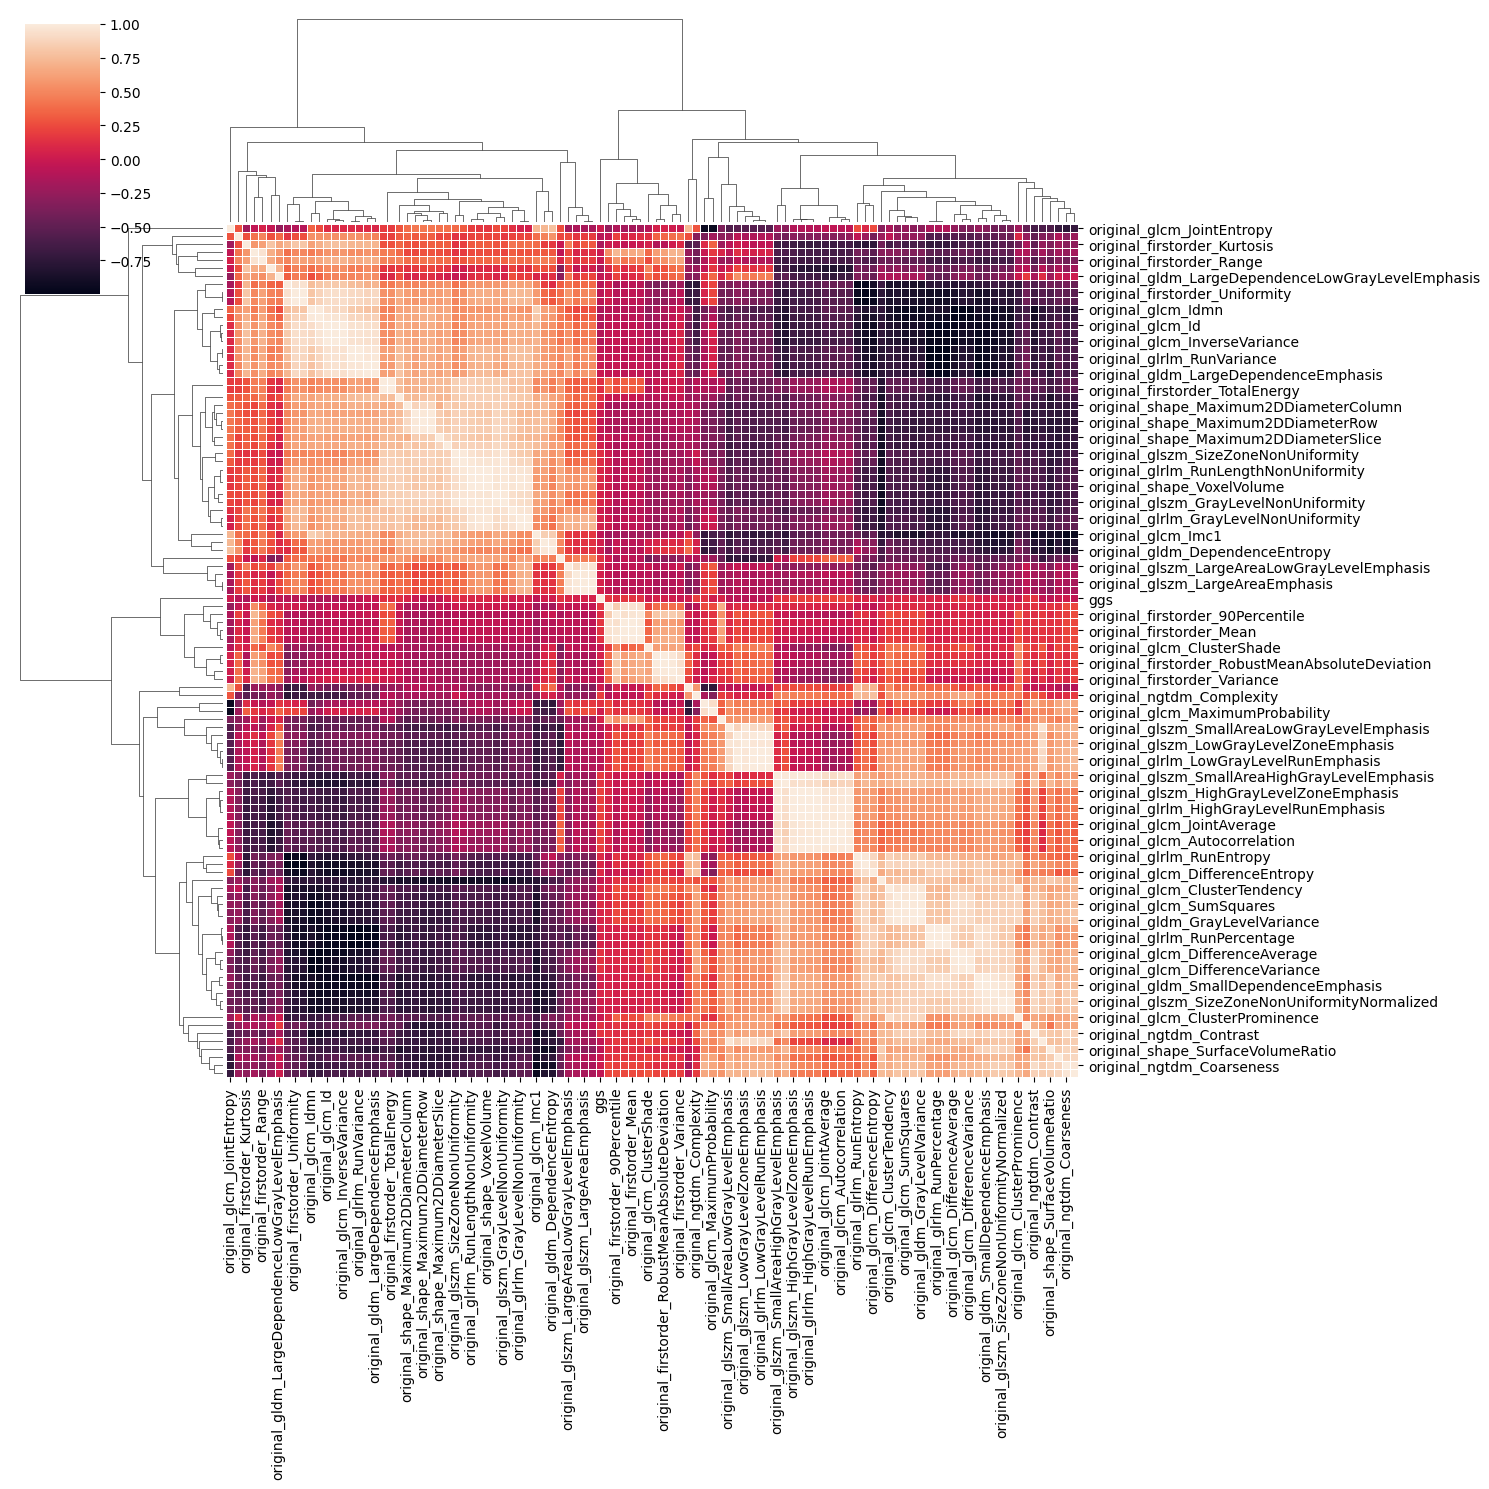

In [141]:
# Choose a subset of features for clustering
d = t2w_df

dd = d.iloc[:,2:]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(15,15))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
pp.savefig("adcPx_crr.png")

plt.show()

# Déterminons les variables les moins corrélés

In [142]:
corrMatrix = t2w_df.corr()

correlated_features = set()
no_correlated_features = set()

for i in range(len(corrMatrix .columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.7:
            colname = corrMatrix.columns[i]
            no_correlated_features.add(colname)

t2w_df.drop(labels=no_correlated_features, axis=1, inplace=True)

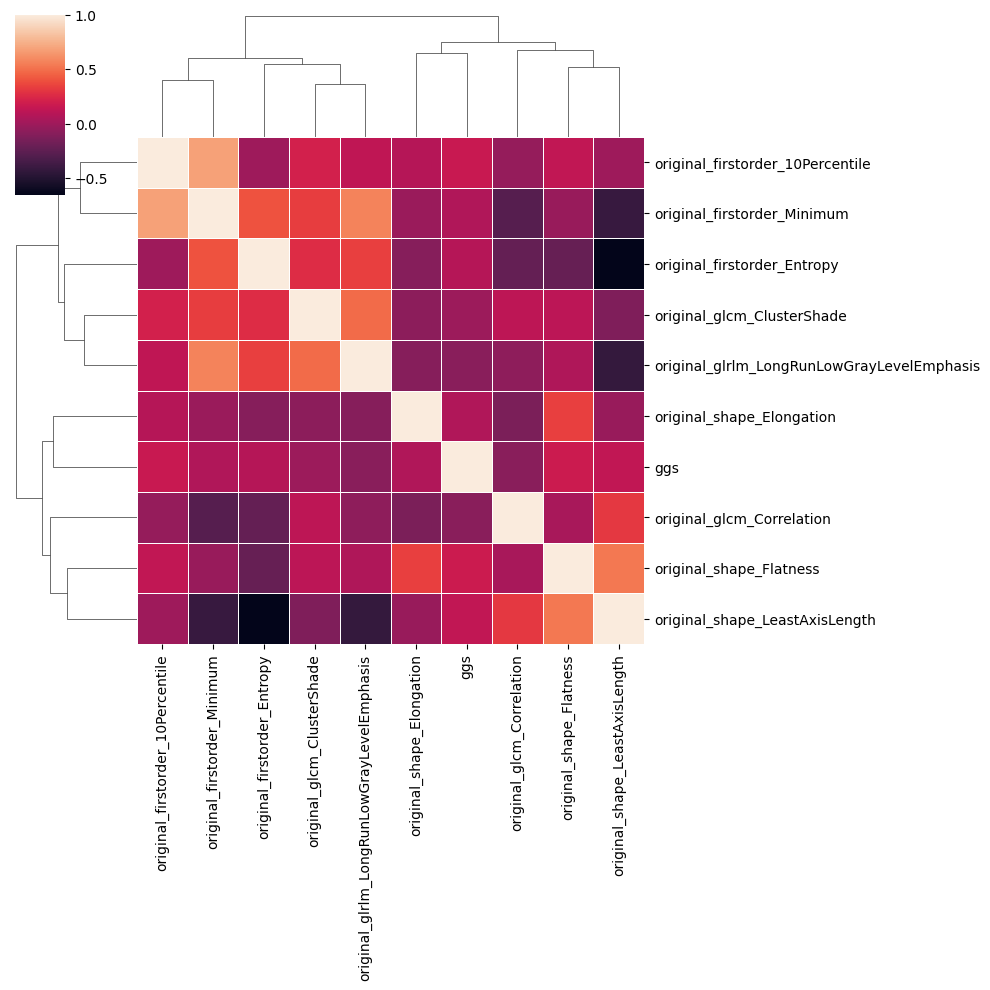

In [143]:
pp = sns.clustermap(t2w_df.corr(), linewidths=.5, figsize=(10,10))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

# pp.savefig("T2PI_crr.png")

plt.show()

# Voici les marqueurs les moins corrélés

In [144]:
t2w_df.columns

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_firstorder_10Percentile',
       'original_firstorder_Entropy', 'original_firstorder_Minimum',
       'original_glcm_ClusterShade', 'original_glcm_Correlation',
       'original_glrlm_LongRunLowGrayLevelEmphasis', 'ggs'],
      dtype='object')

In [145]:
len(t2w_df.columns)

10

# Modèles de classification

Sur la base des marqueurs les moins corrélés, nous allons faire le training de nos modèles de classification

# Matrice de confusion

In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

def conf_matrix(matrix,pred):
    class_names= [0,1,2,3,4,5]# name  of classes
    fig, ax = plt.subplots(figsize=(5,3))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
#     plt.savefig('/home/sama/Documents/Stage_CIC/Data-Archive/01-SAMA_RAD_WORKS/Prostate_Data_Analyses/ProstateX_Features/image.png')
    plt.show()

# Normalisation de nos données

In [147]:
from imblearn.over_sampling import SMOTE
import sklearn as sk

y = t2w_df['ggs']
t2w_df.drop(['ggs'], axis=1, inplace=True)

In [148]:
for column in t2w_df.columns:
    t2w_df[column] = (t2w_df[column] - t2w_df[column].min()) / (t2w_df[column].max() - t2w_df[column].min()) 

In [149]:
t2w_df = pd.concat((t2w_df, y), axis=1)

In [150]:
len(t2w_df)

134

In [151]:
X_train, X_val, y_train, y_val = train_test_split(t2w_df,y,test_size=0.15,random_state=0,shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.1,random_state=0,shuffle = True)

# Modèle Random Forest

In [157]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
import pickle

rf = RandomForestClassifier(class_weight="balanced",n_estimators=200,random_state = 1)
rf.fit(X_train,y_train)

# Enregistrement du modèle sur disque
filename = 'adc_Px_rf_model.pkl'
pickle.dump(rf, open(filename, 'wb'))

y_pred=rf.predict(X_val)
acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))
print("accuracy Score is {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 85.71%
accuracy Score is 85.71%


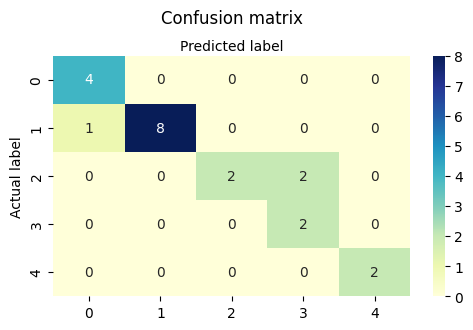

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.89      0.94         9
           3       1.00      0.50      0.67         4
           4       0.50      1.00      0.67         2
           5       1.00      1.00      1.00         2

    accuracy                           0.86        21
   macro avg       0.86      0.88      0.83        21
weighted avg       0.91      0.86      0.86        21

accuracy Score is 85.71%


In [158]:
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(acc))

# Modèle d'arbre de décision

In [159]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3)

dtc = dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_val)

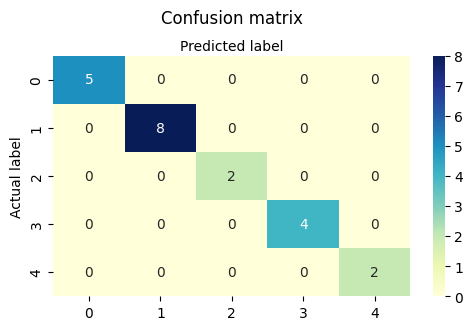

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

accuracy Score is 100.00%


In [160]:
accuracy = accuracy_score(y_val, y_pred)*100
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(accuracy))

# Modèle CatBooster

In [161]:
import catboost as cb

CtBt_model = cb.CatBoostClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1)
CtBt_model.fit(X_train, y_train)

0:	learn: 1.3934898	total: 98.8ms	remaining: 1m 38s
1:	learn: 1.2823699	total: 109ms	remaining: 54.6s
2:	learn: 1.1974749	total: 128ms	remaining: 42.7s
3:	learn: 1.1137295	total: 141ms	remaining: 35.1s
4:	learn: 1.0307458	total: 150ms	remaining: 29.8s
5:	learn: 0.9675894	total: 155ms	remaining: 25.7s
6:	learn: 0.9109155	total: 160ms	remaining: 22.6s
7:	learn: 0.8550370	total: 164ms	remaining: 20.3s
8:	learn: 0.8083756	total: 168ms	remaining: 18.5s
9:	learn: 0.7409595	total: 172ms	remaining: 17s
10:	learn: 0.7125789	total: 175ms	remaining: 15.8s
11:	learn: 0.6937409	total: 179ms	remaining: 14.8s
12:	learn: 0.6564359	total: 183ms	remaining: 13.9s
13:	learn: 0.6445397	total: 187ms	remaining: 13.2s
14:	learn: 0.5957906	total: 190ms	remaining: 12.5s
15:	learn: 0.5525839	total: 193ms	remaining: 11.9s
16:	learn: 0.5293420	total: 196ms	remaining: 11.3s
17:	learn: 0.4918584	total: 199ms	remaining: 10.9s
18:	learn: 0.4569739	total: 202ms	remaining: 10.5s
19:	learn: 0.4258557	total: 205ms	remaini

188:	learn: 0.0128334	total: 863ms	remaining: 3.7s
189:	learn: 0.0127425	total: 868ms	remaining: 3.7s
190:	learn: 0.0126532	total: 871ms	remaining: 3.69s
191:	learn: 0.0125433	total: 878ms	remaining: 3.69s
192:	learn: 0.0124289	total: 881ms	remaining: 3.68s
193:	learn: 0.0123439	total: 889ms	remaining: 3.69s
194:	learn: 0.0122332	total: 894ms	remaining: 3.69s
195:	learn: 0.0121509	total: 907ms	remaining: 3.72s
196:	learn: 0.0120668	total: 909ms	remaining: 3.71s
197:	learn: 0.0119665	total: 911ms	remaining: 3.69s
198:	learn: 0.0118851	total: 916ms	remaining: 3.69s
199:	learn: 0.0118069	total: 919ms	remaining: 3.68s
200:	learn: 0.0117276	total: 923ms	remaining: 3.67s
201:	learn: 0.0116495	total: 931ms	remaining: 3.68s
202:	learn: 0.0115742	total: 934ms	remaining: 3.67s
203:	learn: 0.0115245	total: 936ms	remaining: 3.65s
204:	learn: 0.0114271	total: 938ms	remaining: 3.64s
205:	learn: 0.0113546	total: 941ms	remaining: 3.63s
206:	learn: 0.0112601	total: 943ms	remaining: 3.61s
207:	learn: 0.

395:	learn: 0.0048683	total: 1.62s	remaining: 2.47s
396:	learn: 0.0048544	total: 1.62s	remaining: 2.46s
397:	learn: 0.0048402	total: 1.63s	remaining: 2.46s
398:	learn: 0.0048227	total: 1.64s	remaining: 2.47s
399:	learn: 0.0048087	total: 1.65s	remaining: 2.47s
400:	learn: 0.0047951	total: 1.65s	remaining: 2.46s
401:	learn: 0.0047816	total: 1.65s	remaining: 2.45s
402:	learn: 0.0047644	total: 1.66s	remaining: 2.46s
403:	learn: 0.0047469	total: 1.67s	remaining: 2.46s
404:	learn: 0.0047300	total: 1.68s	remaining: 2.47s
405:	learn: 0.0047214	total: 1.68s	remaining: 2.46s
406:	learn: 0.0047083	total: 1.68s	remaining: 2.45s
407:	learn: 0.0046953	total: 1.69s	remaining: 2.45s
408:	learn: 0.0046824	total: 1.7s	remaining: 2.46s
409:	learn: 0.0046691	total: 1.7s	remaining: 2.45s
410:	learn: 0.0046523	total: 1.7s	remaining: 2.44s
411:	learn: 0.0046392	total: 1.71s	remaining: 2.44s
412:	learn: 0.0046262	total: 1.72s	remaining: 2.44s
413:	learn: 0.0046136	total: 1.72s	remaining: 2.43s
414:	learn: 0.0

564:	learn: 0.0031892	total: 2.22s	remaining: 1.71s
565:	learn: 0.0031832	total: 2.22s	remaining: 1.7s
566:	learn: 0.0031752	total: 2.23s	remaining: 1.7s
567:	learn: 0.0031692	total: 2.23s	remaining: 1.7s
568:	learn: 0.0031615	total: 2.24s	remaining: 1.7s
569:	learn: 0.0031536	total: 2.24s	remaining: 1.69s
570:	learn: 0.0031477	total: 2.25s	remaining: 1.69s
571:	learn: 0.0031417	total: 2.26s	remaining: 1.69s
572:	learn: 0.0031339	total: 2.26s	remaining: 1.68s
573:	learn: 0.0031279	total: 2.26s	remaining: 1.68s
574:	learn: 0.0031219	total: 2.27s	remaining: 1.67s
575:	learn: 0.0031159	total: 2.27s	remaining: 1.67s
576:	learn: 0.0031085	total: 2.28s	remaining: 1.67s
577:	learn: 0.0031009	total: 2.28s	remaining: 1.67s
578:	learn: 0.0030935	total: 2.29s	remaining: 1.66s
579:	learn: 0.0030860	total: 2.3s	remaining: 1.66s
580:	learn: 0.0030802	total: 2.3s	remaining: 1.66s
581:	learn: 0.0030744	total: 2.3s	remaining: 1.65s
582:	learn: 0.0030688	total: 2.3s	remaining: 1.65s
583:	learn: 0.003063

759:	learn: 0.0022786	total: 3s	remaining: 948ms
760:	learn: 0.0022745	total: 3s	remaining: 944ms
761:	learn: 0.0022714	total: 3.01s	remaining: 939ms
762:	learn: 0.0022701	total: 3.01s	remaining: 935ms
763:	learn: 0.0022670	total: 3.01s	remaining: 931ms
764:	learn: 0.0022629	total: 3.02s	remaining: 926ms
765:	learn: 0.0022589	total: 3.02s	remaining: 922ms
766:	learn: 0.0022559	total: 3.02s	remaining: 918ms
767:	learn: 0.0022519	total: 3.02s	remaining: 914ms
768:	learn: 0.0022500	total: 3.03s	remaining: 910ms
769:	learn: 0.0022461	total: 3.03s	remaining: 906ms
770:	learn: 0.0022442	total: 3.03s	remaining: 901ms
771:	learn: 0.0022411	total: 3.04s	remaining: 897ms
772:	learn: 0.0022371	total: 3.04s	remaining: 893ms
773:	learn: 0.0022333	total: 3.04s	remaining: 889ms
774:	learn: 0.0022295	total: 3.05s	remaining: 884ms
775:	learn: 0.0022256	total: 3.06s	remaining: 882ms
776:	learn: 0.0022227	total: 3.06s	remaining: 879ms
777:	learn: 0.0022197	total: 3.06s	remaining: 875ms
778:	learn: 0.0022

954:	learn: 0.0017812	total: 3.79s	remaining: 179ms
955:	learn: 0.0017793	total: 3.79s	remaining: 175ms
956:	learn: 0.0017768	total: 3.8s	remaining: 171ms
957:	learn: 0.0017744	total: 3.8s	remaining: 167ms
958:	learn: 0.0017725	total: 3.81s	remaining: 163ms
959:	learn: 0.0017713	total: 3.82s	remaining: 159ms
960:	learn: 0.0017688	total: 3.82s	remaining: 155ms
961:	learn: 0.0017668	total: 3.82s	remaining: 151ms
962:	learn: 0.0017643	total: 3.83s	remaining: 147ms
963:	learn: 0.0017619	total: 3.83s	remaining: 143ms
964:	learn: 0.0017600	total: 3.84s	remaining: 139ms
965:	learn: 0.0017581	total: 3.84s	remaining: 135ms
966:	learn: 0.0017570	total: 3.85s	remaining: 131ms
967:	learn: 0.0017551	total: 3.85s	remaining: 127ms
968:	learn: 0.0017532	total: 3.86s	remaining: 123ms
969:	learn: 0.0017513	total: 3.86s	remaining: 119ms
970:	learn: 0.0017495	total: 3.87s	remaining: 116ms
971:	learn: 0.0017477	total: 3.87s	remaining: 112ms
972:	learn: 0.0017453	total: 3.87s	remaining: 108ms
973:	learn: 0.

In [162]:
y_pred = CtBt_model.predict(X_val)
acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("accuracy Score is {:.2f}%".format(acc))

accuracy Score is 100.00%


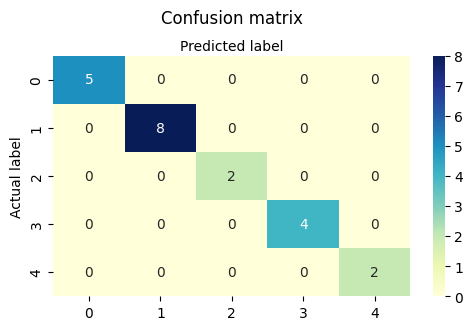

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

accuracy Score is 100.00%


In [163]:
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(acc))

# Modèle LightGBM

In [164]:
import lightgbm as lgb

LtGBM_model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, learning_rate=0.1)
LtGBM_model.fit(X_train, y_train)

LGBMClassifier(max_depth=3, n_estimators=1000)

In [165]:
y_pred = LtGBM_model.predict(X_val)
acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("accuracy Score is {:.2f}%".format(acc))

accuracy Score is 100.00%


# Modèle AdaBoostClassifier

In [166]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=1000, random_state=42)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=1000, random_state=42)

In [167]:
y_pred = adaboost.predict(X_val)

acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("accuracy Score is {:.2f}%".format(acc))

accuracy Score is 42.86%


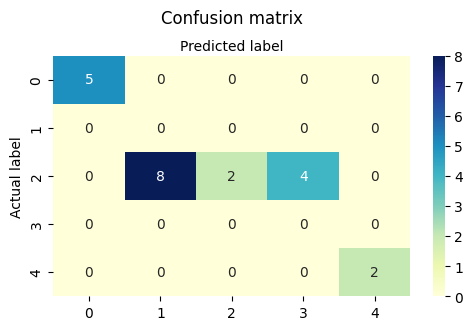

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         0
           3       1.00      0.14      0.25        14
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         2

    accuracy                           0.43        21
   macro avg       0.60      0.43      0.45        21
weighted avg       1.00      0.43      0.50        21

accuracy Score is 42.86%


/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [168]:
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(acc))

# GradientBoostingRegressor

In [169]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

gb_regressor = GradientBoostingRegressor(n_estimators=1000, random_state=42)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [170]:
y_pred = adaboost.predict(X_val)

acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("accuracy Score is {:.2f}%".format(acc))

# mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)

accuracy Score is 42.86%


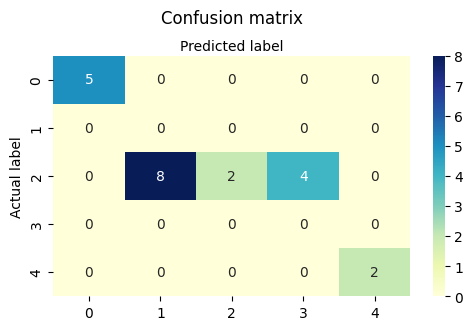

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         0
           3       1.00      0.14      0.25        14
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         2

    accuracy                           0.43        21
   macro avg       0.60      0.43      0.45        21
weighted avg       1.00      0.43      0.50        21

accuracy Score is 42.86%


/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sama/Documents/Stage_CIC/radiomicenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [171]:
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(acc))

# HistGradientBoostingClassifier

In [172]:
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_classification

hist_gb_classifier = HistGradientBoostingClassifier(random_state=42)
hist_gb_classifier.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [173]:
y_pred = hist_gb_classifier.predict(X_val)

acc = metrics.accuracy_score(y_pred,y_val.values.ravel())*100
print("accuracy Score is {:.2f}%".format(acc))

accuracy Score is 80.95%


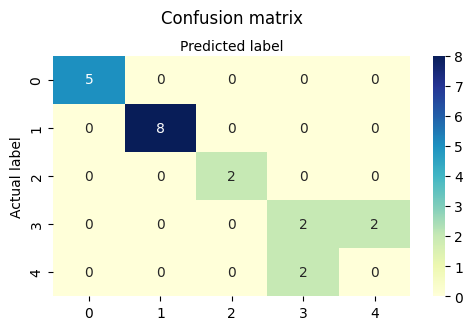

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         2
           4       0.50      0.50      0.50         4
           5       0.00      0.00      0.00         2

    accuracy                           0.81        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.81      0.81      0.81        21

accuracy Score is 80.95%


In [174]:
cnf_matrix = metrics.confusion_matrix(y_pred,y_val)
conf_matrix(cnf_matrix,y_val)
# calculate prediction
report = classification_report(y_pred,y_val)
print(report)

print("accuracy Score is {:.2f}%".format(acc))